In [ ]:
from scipy.io import loadmat
from scipy.signal import butter, filtfilt
import numpy as np
import pandas as pd

# Load the .mat file
mat_file = loadmat('eeg_record1.mat')

# Extract data

In [ ]:
def extract_raw_data(mat_file: dict) -> pd.DataFrame:
    def get_state(timestamp) -> str:
        if timestamp <= 10*128*60:
            return 0 # 0 is focussed
        elif timestamp > 20*128*60:
            return 2 # drownsy
        else:
            return 1

    o = mat_file['o'] # data inside key 'o'
    data = o[0][0]['data'][:, 3:17]
    columns_name = ['AF3', 'F7', ' F3', ' FC5', 'T7', 'P7', 'O1',
                    'O2', 'P8', 'T8', 'FC6', ', '
    eeg_data = pd.DataFrame(data, columns = columns_name)
    
    # eeg_data.reset_index(inplace=True)
    # eeg_data.rename(columns={'index': 'timestamp'}, inplace=True)
    # eeg_data['state'] = eeg_data['timestamp'].apply(get_state)

    return eeg_data

# 128 samples (128 Hz) are recorded per second
eeg_data = extract_raw_data(mat_file)
        

# Bandpass filtering

In [ ]:
lowcut = 0.5  # Lower bound of the band (Hz)
highcut = 40  # Upper bound of the band (Hz)
fs = 128  # Sampling frequency (Hz)

def butterworth_bandpass(low_bp, high_bp, fs, order=4):
    nyquist = 0.5 * fs
    low = low_bp / nyquist
    high = high_bp / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

b, a = butterworth_bandpass(lowcut, highcut, fs)
f_eeg_data = filtfilt(b, a, eeg_data, axis=0)

In [ ]:
import numpy as np
from sklearn.decomposition import FastICA
# from sklearn.metrics import mean_squarerror  # Correct import
import matplotlib.pyplot as plt

def compute_cosine_similarity(A, B):
    return np.dot(A, B) / (np.linalg.norm(A) * np.linalg.norm(B))
    dot_product = np.dot(A, B)

cosine_sims = []
# Loop over different numbers of components
for n in range(1, f_eeg_data.shape[1] + 1):
    ica = FastICA(n_components=n, random_state=42)
    S = ica.fit_transform(f_eeg_data)  # Independent sources
    A = ica.mixing_  # Mixing matrix
    temp = np.dot(S, A.T) # Reconstruct the observed signals

    # Compute the reconstruction error using Mean Squared Error (MSE)
    sim = np.mean([compute_cosine_similarity(temp[:, i], f_eeg_data[:, i]) for i in range(f_eeg_data.shape[1])])
    print(f'n = {n} - Cosine Similarity: {sim}')
    cosine_sims.append(sim)



In [ ]:
plt.figure(figsize=(10, 3))
plt.plot(range(1, f_eeg_data.shape[1] + 1), cosine_sims, marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity vs Number of Components')
plt.grid()
plt.show()

In [ ]:
n = np.argmax(cosine_sims) + 1
ica = FastICA(n_components=n, random_state=42)
S = ica.fit_transform(f_eeg_data)  # Independent sources
A = ica.mixing_  # Mixing matrix

r_eeg_data = np.dot(S, A.T)  # Reconstruct the observed signals

# Apply Fourier Transform

In [106]:
fft_data = np.fft.fft(r_eeg_data, axis=0)
freqs = np.fft.fftfreq(r_eeg_data.shape[0], 1/fs)

N = fft_data.shape[0] # get positive frequencies
pos_fft_data = fft_data[:N//2, :]
pos_freqs = freqs[:N//2]

power_spectrum_data = np.square(np.abs(pos_fft_data)) / N
psd_data = power_spectrum_data / fs

Compute $PSD = power\_spectrum / fs = power / (N*fs) = |X|^2 / (N*fs)$

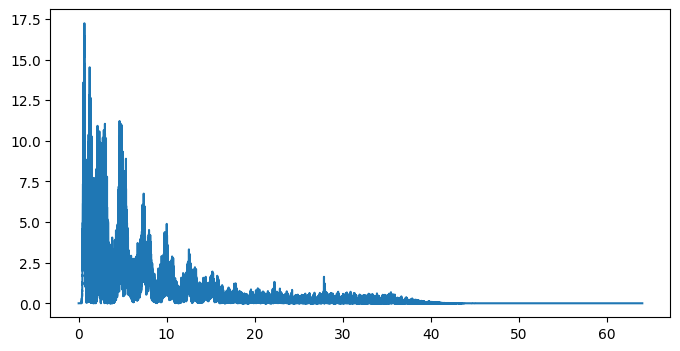

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(pos_freqs[:].real, psd_data[:,0])
plt.show()

In [ ]:
states_data = [
    psd_data[:10*128*60, :], # focus
    psd_data[10*128*60:20*128*60, :], # unfocus
    psd_data[20*128*60:, :] # drowsy
]

states_freq = [
    pos_freqs[:10*128*60],
    pos_freqs[10*128*60:20*128*60],
    pos_freqs[20*128*60:]
]


band_waves = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30),
    'gamma': (30, 100)
}

columns_name = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1',
                    'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

new_data = []
for f, state_data in enumerate(states_data):
    for i in range(2):
        channel = state_data[:, i]
        sample = {}
        
        for wave in band_waves:
            low, high = band_waves[wave]
            band_data = channel[(states_freq[f] >= low) & (states_freq[f] < high)]
            sample[f'{wave}'] = np.mean(band_data)

        sample['channel'] = columns_name[i]

        if f == 0:
            sample['state'] = 'focus'
        elif f == 1:
            sample['state'] = 'unfocus'
        else:
            sample['state'] = 'drownsy'

        new_data.append(sample)
    

c:\Users\dangm\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\dangm\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [124]:
for f, state_data in enumerate(states_data):
    for i in range(1):
        channel = state_data[:, i]
        sample = {}
        
        for wave in band_waves:
            low, high = band_waves[wave]
            band_data = channel[(states_freq[f] >= low) & (states_freq[f] < high)]
            sample[f'{wave}'] = np.mean(band_data)

        sample['channel'] = columns_name[i]

        if f == 0:
            sample['state'] = 'focus'
        elif f == 1:
            sample['state'] = 'unfocus'
        else:
            sample['state'] = 'drownsy'

        new_data.append(sample)

In [131]:
f = 1
channel = states_data[f][:, i]

for wave in band_waves:
    low, high = band_waves[wave]
    band_data = channel[(states_freq[f] >= low) & (states_freq[f] < high)]
    print(np.sum(band_data))

0.0
0.0
0.0
0.0
1644.3373116522664


In [132]:
channel

array([1.13313006e-01, 3.34938210e-02, 1.22929856e-01, ...,
       5.46111041e-08, 5.46110615e-08, 5.46110190e-08])